##### Some imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import subprocess
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import astropy.units as u
from astropy.time import Time
from astropy.coordinates.name_resolve import NameResolveError
from astropy.coordinates import EarthLocation, AltAz, get_body
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS

from ligo.skymap.io.fits import read_sky_map
import healpy as hp
import scipy.ndimage

import plotting
import utils_scheduling as utils

/fefs/aswg/workspace/juan.jimenez/.conda/envs/baseenv/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


# Parameters

In [2]:
# Reference time for the plot
t_ref = datetime.utcnow() # datetime.fromisoformat("20240125 23:00:00")

# --- Time bins --- #
# X-axis number of bins, or frames for the animation
nbins = 700
# Number of hours before/after sunset/sunrise to be uses in animation
animation_hours_sun = 2
# If set to true the animation is performed for full day
animation_full_day = False

# --- Other options --- #
# Show solar system relevant bodies and som extra as crab or galactic center
show_bodies = True
# Showing bright stars in the FoV
show_stars = False
# Showing galactic plane and galactic center
show_galplane = False
# Showing GW coverage 
show_gw = False
file_ligo = "data/gw_data/bayestar.multiorder.fits" # "data/bayestar.multiorder.fits" 
name_gw = "S241005dq"

# If plots need to be stored
store_plots = True
animation_format = "mp4" # "gif" or "mp4" can be used

# --- Some "fixed" options --- #
# Observing location on Earth
location = EarthLocation.of_site("Roque de los Muchachos")
# Show current time in plots when relevant
show_time_now = False
# File with MAGIC raw schedule format txt
file_schedule = "data/schedule.txt"

##### Time information & moon information

In [3]:
# Time bins used for 1 day plot
print(f"Number of time bins: {nbins} of {24 * 60 / nbins:.2f} min each.")

# Taking the reference dates based on the reference time provided
# the 24h to be plotted are from 12 a.m to 12 a.m
ref_year, ref_month, ref_day, ref_hour = t_ref.year, t_ref.month, t_ref.day, t_ref.hour

# Then we build the midnight time, or central time
if ref_hour < 12.0:
    t_midnight = datetime(year=ref_year, month=ref_month, day=ref_day) 
elif ref_hour > 12.0:
    t_midnight = datetime(year=ref_year, month=ref_month, day=ref_day) + timedelta(days=1)

# Actual time
t_now =  datetime.utcnow()

# Night reference, day when the night starts
t_night_ref = t_midnight - timedelta(seconds=1)
# Reference night-string for the schedule
ref_day_str = f" {t_night_ref.day}.{t_night_ref.month}.{t_night_ref.year}"

# Then we also produce the time binning that we will be using for everything
time_sample = pd.date_range(t_midnight - timedelta(hours=12), t_midnight + timedelta(hours=12), nbins)
print(f"\nInformation from {time_sample[0]} to {time_sample[-1]}")


# If t_midnight and t_now differ > 8h we show current time in the plots
if np.abs(t_midnight - datetime.utcnow()).total_seconds() / 3600 < 8.0 and show_time_now:
    t_isnow = True
else:
    t_isnow = False

# We also get the AltAz frame for all the observations
altaz_frame = AltAz(obstime=time_sample, location=location)

# We run the moon.py script to generate a image of the moon and
# to get the current moon phase percentage of ilumination
subprocess.run(f"python moon.py {str(t_midnight)}", shell=True)
moon_fraction = np.loadtxt("data/moon_data/moon.txt", dtype="str", delimiter="+")[1].astype(float) / 100
print(f"\nCurrent moon phase is {moon_fraction*100:.1f}% illuminated.")

Number of time bins: 700 of 2.06 min each.

Information from 2024-10-07 12:00:00 to 2024-10-08 12:00:00

Current moon phase is 23.3% illuminated.


##### Reading schedule txt

In [4]:
dict_schedule_night = utils.read_magic_schedule(
    file_schedule, 
    ref_day_str, 
    t_night_ref, 
    t_midnight
)

# Source coordinates
source_names = [key for key in dict_schedule_night.keys()]
source_coords = [dict_schedule_night[key]["coord"] for key in source_names]
for i, key in enumerate(source_names):
    coord = source_coords[i]
    print(f"\n{i}: {key} ICRS\n{coord.ra.deg:.2f} deg {coord.dec.deg:.2f} deg")
    print(f"{coord.ra.to_string(unit='hourangle',sep=':')} hms, {coord.dec.to_string(unit='degree',sep=':')} dms")


0: LHAASOJ2002+3244u ICRS
300.64 deg 32.74 deg
20:02:34 hms, 32:44:24.01 dms

1: LHAASOJ0056+6346u ICRS
14.10 deg 63.77 deg
0:56:24 hms, 63:46:12 dms

2: 1ES0229+200 ICRS
38.20 deg 20.29 deg
2:32:48 hms, 20:17:17 dms

3: Boomerang_Tail ICRS
336.83 deg 60.92 deg
22:27:18.96 hms, 60:55:08.4 dms


#### Information about sources, moon and sun

In [5]:
# Zoom parameters for the images/icons representing each body
moon_zoom = 0.055
sun_zoom  = 0.015

# We extract the ra-dec coordinates of moon and sun
moon_icrs = get_body("moon", Time(time_sample), location)
sun_icrs  = get_body("sun",  Time(time_sample), location)

# And then we convert it to altaz
moon_altaz = moon_icrs.transform_to(altaz_frame)
sun_altaz  = sun_icrs.transform_to( altaz_frame)

# --- AltAz for sources --- #
sources_altaz = [c.transform_to(altaz_frame) for c in source_coords]

# --- Computing mask for the scheduled observation times --- #
masked_times, masked_alts, masks_obstime = [], [], []
for k, source_altaz in enumerate(sources_altaz[:]):
    # Plotting the timespan where the source is being observed
    submasks = []
    for j in range(len(dict_schedule_night[source_names[k]]["tstart"])):
        submasks.append((Time(time_sample) > dict_schedule_night[source_names[k]]["tstart"][j]) & 
                        (Time(time_sample) < dict_schedule_night[source_names[k]]["tstop"][j]))
    mask_obstime = submasks[0]
    for j in range(len(submasks)-1):
        mask_obstime = mask_obstime | submasks[j+1]
    masks_obstime.append(mask_obstime)
    
    masked_times.append(np.where(mask_obstime, time_sample.astype("object"), None))
    masked_alts.append(np.where(mask_obstime, sources_altaz[k].alt.deg, None))
    

#### Information about the dark time and luminosity of night

In [6]:
# Getting dark time, night interval, twilight interval etc...
mask_dark_time = ((moon_altaz.alt.deg < -0.7) & (sun_altaz.alt.deg < -18))
mask_night = sun_altaz.alt.deg < -18
mask_twilight = sun_altaz.alt.deg < 0
mask_day = np.invert(mask_twilight)

# Start and finish times for each interval
if np.sum(mask_dark_time) > 0:
    t_start_dark, t_stop_dark = time_sample[mask_dark_time][0], time_sample[mask_dark_time][-1]
else:
    t_start_dark, t_stop_dark = t_midnight, t_midnight
t_start_night, t_stop_night = time_sample[mask_night][0], time_sample[mask_night][-1]
t_start_twilight, t_stop_twilight = time_sample[mask_twilight][0], time_sample[mask_twilight][-1]

# Simple modelling of sky light
# 1 means day, 0 means dark night time
light_day = mask_day.astype("float") * 1.0
light_twilight = (mask_twilight.astype(float) *  np.invert(mask_night).astype(float)) * 0.7
# Moon fraction contribution ot light
light_moon = (mask_night.astype(float) *  np.invert(mask_dark_time).astype(float)) * moon_fraction * 0.6
# Then putting all together and interpolating between steps
light_mask = utils.local_interpolation(light_day + light_twilight + light_moon, int(nbins * 50 / 1000))

# Calculating the amount of night and dark time
tdelta_night, tdelta_dark = (t_stop_night-t_start_night).total_seconds(), (t_stop_dark-t_start_dark).total_seconds()

print(f"On night of {t_midnight - timedelta(seconds=1)}:")
print(f"\n- Amount of night time: {tdelta_night / 3600:.2f} hours")
print(f"\n- Amount of dark time: {tdelta_dark / 3600:.2f} hours ({tdelta_dark/tdelta_night*100:.2f}%)")

# We also compute the reduced time_sample array for the animation
if animation_full_day:
    time_sample_reduced = time_sample.copy()
    
    # AltAz frame
    altaz_frame_reduced = altaz_frame.copy()
    
    animation_frame_indexes = len(time_sample)

else:
    # Computing the number of bins relative to the number of hours 
    # before/after the sunset/sunrise 
    frames_to_hours = int(nbins / 24 * animation_hours_sun)

    index_night_start = np.where(light_mask != 1.0)[0][0]  - frames_to_hours
    index_night_stop  = np.where(light_mask != 1.0)[0][-1] + frames_to_hours

    time_sample_reduced = time_sample[index_night_start : index_night_stop]
    
    # AltAz frame
    altaz_frame_reduced = AltAz(obstime=time_sample_reduced, location=location)

    animation_frame_indexes = np.arange(index_night_start, index_night_stop)

On night of 2024-10-07 23:59:59:

- Amount of night time: 9.65 hours

- Amount of dark time: 8.24 hours (85.41%)


##### Computing AltAz coordinates for the animation of some objects

In [7]:
%%time
# --- Important bodies --- #
if show_bodies:
    # Bodies zoom for the plots
    bodies_zoom = [sun_zoom, 0.021, 0.015, 0.01, 0.032, 0.007]
    # Also the body names
    bodies_names = ["sun", "Jupiter", "Mars", "Saturn"]

    # Getting positions in ICRS of solar system bodies
    bodies_icrs = [get_body(n, Time(time_sample_reduced), location) for n in bodies_names]

    # Extra bodies from outside the solar system
    bodies_names.append("Crab")
    bodies_icrs.append(SkyCoord.from_name("Crab"))
    
    # Then transforming to AltAz frames
    bodies_altaz = [b.transform_to(altaz_frame_reduced) for b in bodies_icrs]

# --- Vmag < 3.5 Stars --- #
if show_stars:
    
    # Getting the stars with the needed magnitud at least 3.5 from already computed table
    tab_stars = pd.read_csv("data/table_bright_stars_vmag3.5.csv")
    
    # Then getting the coordinates and converting to AltAz
    stars_mags = np.array(tab_stars["FLUX_V"])
    stars_icrs = SkyCoord(tab_stars["RA"], tab_stars["DEC"], unit=(u.hourangle, u.deg))
    stars_altaz = [s.transform_to(altaz_frame_reduced) for s in stars_icrs]

# --- Coordinates of galactic plane --- #
if show_galplane:
    nsample_galplane  = 50
    galplane_icrs = SkyCoord(
        l=np.linspace(-180, 220, nsample_galplane), # We extend to 120 to not leave gaps
        b=np.repeat(0, nsample_galplane), 
        unit=u.deg, frame="galactic"
    ).fk5
    galplane_altaz = [p.transform_to(altaz_frame_reduced) for p in galplane_icrs]
    
    # Then for the galactic center itself
    galcen_icrs = SkyCoord(l=0, b=0, unit=u.deg, frame="galactic").fk5
    galcen_altaz = galcen_icrs.transform_to(altaz_frame_reduced)
    
    # Getting an array for each time of time sample
    galplane_zd_time, galplane_az_time = [], []
    for j in range(len(time_sample_reduced)):
        _alt_, _az_ = [], []
        for point_galplane in galplane_altaz:
            _alt_.append(point_galplane.alt.deg[j])
            _az_.append(point_galplane.az.deg[j])
        galplane_zd_time.append(np.deg2rad(90 - np.array(_alt_)))
        galplane_az_time.append(np.deg2rad(_az_))

CPU times: user 3.92 s, sys: 1.45 ms, total: 3.92 s
Wall time: 3.94 s


##### Computing AltAz for GW object 
Import fits file from  https://gracedb.ligo.org/

In [8]:
%%time
if show_gw:
    nskip_contours = 20
    lim_contours = 200
    resolution_hp_to_grid = 2048
    
    data_ligo_hp, meta_ligo_hp = read_sky_map(file_ligo) 
    nside = hp.npix2nside(len(data_ligo_hp))
    
    # Check if the length of the array matches 12 * nside^2
    if len(data_ligo_hp) != 12 * nside**2:
        raise ValueError("Length of the probabilities array does not match 12 * nside^2")
        
    # Convert the HEALPix data to a 2D grid
    # Define the resolution of the grid
    lon = np.linspace(-180, 180, resolution_hp_to_grid)
    lat = np.linspace(-90, 90, resolution_hp_to_grid)
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    
    # Convert the latitude and longitude to theta and phi
    theta = np.radians(90 - lat_grid)
    phi = np.radians(lon_grid)
    
    # Convert theta, phi to HEALPix indices
    hp_indices = hp.ang2pix(nside, theta, phi)
    
    # Create a 2D map using the HEALPix data
    map_ligo_2d = data_ligo_hp[hp_indices] 
    
    sorted_data = np.sort(data_ligo_hp)[::-1]  # Sort in descending order
    cumulative_sum = np.cumsum(sorted_data)
    
    # Find the values corresponding to the 68% and 90% thresholds
    index_68 = np.searchsorted(cumulative_sum, 0.68)
    index_90 = np.searchsorted(cumulative_sum, 0.90)
    threshold_68 = sorted_data[min(index_68, len(sorted_data) - 1)]
    threshold_90 = sorted_data[min(index_90, len(sorted_data) - 1)]
    
    # Smoothing the maps
    map_ligo_2d_smooth = scipy.ndimage.zoom(map_ligo_2d, 2)
    
    # Getting the contour coordinates
    contours_gw = plt.contour(
        map_ligo_2d_smooth, levels=[threshold_90, threshold_68], 
        colors="w", origin="lower", extent=[-180, 180, -90, 90],
    )
    plt.close()
    contour_coords_icrs = contours_gw.allsegs
    
    # Then we extract the contours as individual points
    _ra_, _dec_ = [], []
    for i in range(len(contour_coords_icrs)):
        for j in range(len(contour_coords_icrs[i])):
            if len(contour_coords_icrs[i][j]) > lim_contours:
                # for k in range(len(contour_coords_icrs[i][j])):  
                _ra_.extend(contour_coords_icrs[i][j][:,0][::])
                _dec_.extend(contour_coords_icrs[i][j][:,1][::])
    
    # Then we convert to AltAz
    alt_contour, az_contour = [], []
    for t in range(len(time_sample_reduced)):
        # print(t) if t%100 == 0 else None
        coords = SkyCoord(
            _ra_[::nskip_contours],
            _dec_[::nskip_contours],
            unit=u.deg
        ).transform_to(altaz_frame_reduced[t])
        
        alt_contour.append(coords.alt.deg)
        az_contour.append(coords.az.deg)

CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 10 μs


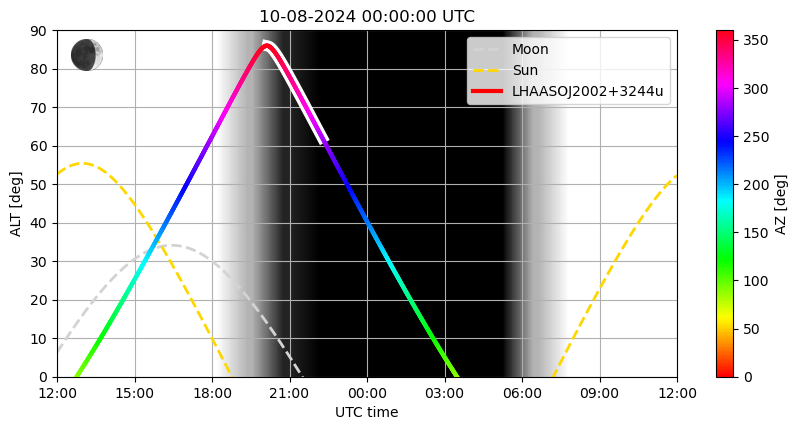

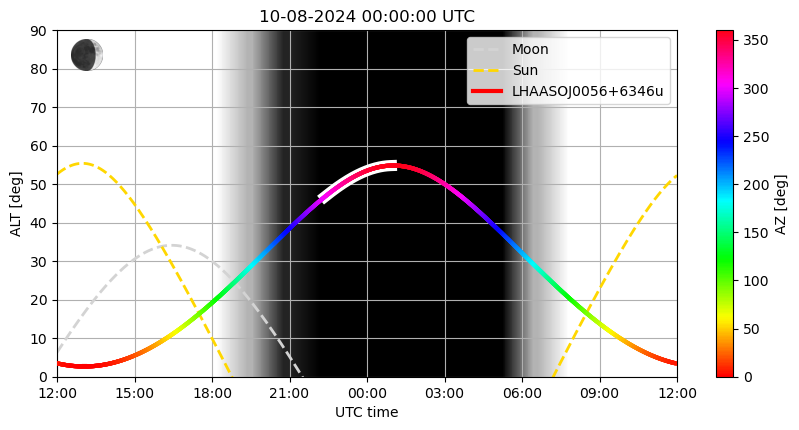

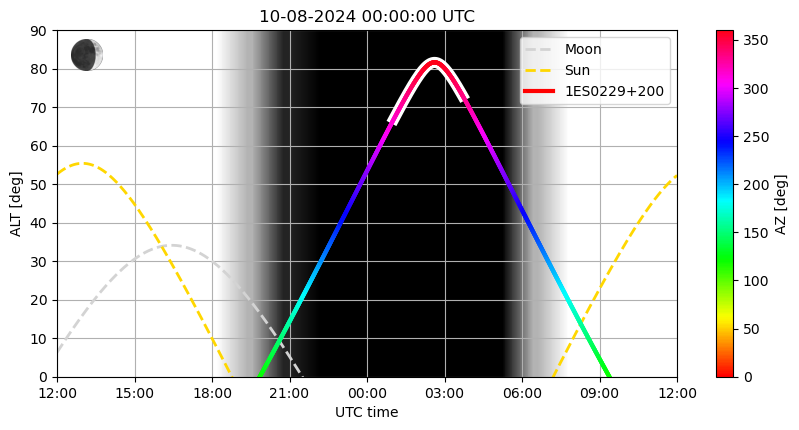

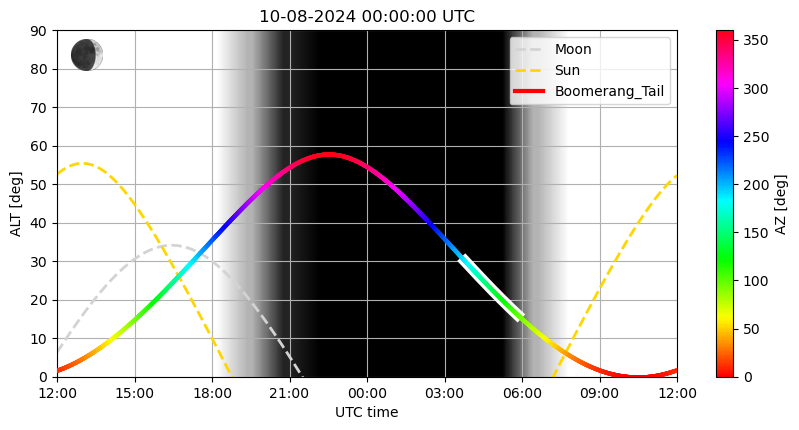

In [9]:
for k in range(len(source_names)):

    fig, ax = plt.subplots(figsize=(10, 4.5))
    
    # --- Moon and Sun positions --- #
    ax.plot(time_sample, moon_altaz.alt.deg, label="Moon", color="lightgray", ls="--", lw=2)
    ax.plot(time_sample, sun_altaz.alt.deg, label="Sun", color="gold", ls="--", lw=2)
    
    # --- Position of source --- #
    _, colors = plotting.get_cmap_colors(sources_altaz[k].alt.deg, "hsv")
    ax.plot([], [], color="r", lw=3, label=source_names[k])
    for j in range(len(time_sample)-2):
        ax.plot(time_sample[j:j+2], sources_altaz[k].alt.deg[j:j+2], "-", color=colors[j], lw=3, zorder=9)

    # Marking the observation time
    ax.plot(masked_times[k], masked_alts[k], "-", color="w", lw=8, zorder=8)

    
    # --- Dark time windows and actual time --- #
    if show_time_now:
        ax.axvline(t_ref, color="r", ls="--", label="Now (UTC)")
    ligh_mask_matrix = np.tile(light_mask, (5, 1))
    ax.pcolormesh(time_sample, np.linspace(0,90,5), ligh_mask_matrix,  cmap="gray")

    # --- Moon phase representation --- #
    newax = fig.add_axes((0.1, 0.79, 0.07, 0.07), anchor="NE", zorder=1)
    newax.imshow(plt.imread("data/moon_data/phase.png"))
    newax.axis("off")
    
    # --- Plot parameters --- #
    ax.legend(loc=1); ax.grid()
    ax.set_xlabel("UTC time"); ax.set_ylabel("ALT [deg]")
    ax.set_ylim(0, 90); ax.set_xlim(time_sample[0], time_sample[-1])
    ax.set_title(t_midnight.strftime("%m-%d-%Y %H:%M:%S") + " UTC")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    plotting.plot_colorbar(fig, ax, [0, 360], "hsv", label="AZ [deg]") # Azimuth colorbar
    
    if store_plots:
        plt.savefig(
            f"output/plot_{source_names[k]}_{t_night_ref.strftime('%m-%d-%Y')}.png", 
            bbox_inches="tight", dpi=300)
    plt.show()

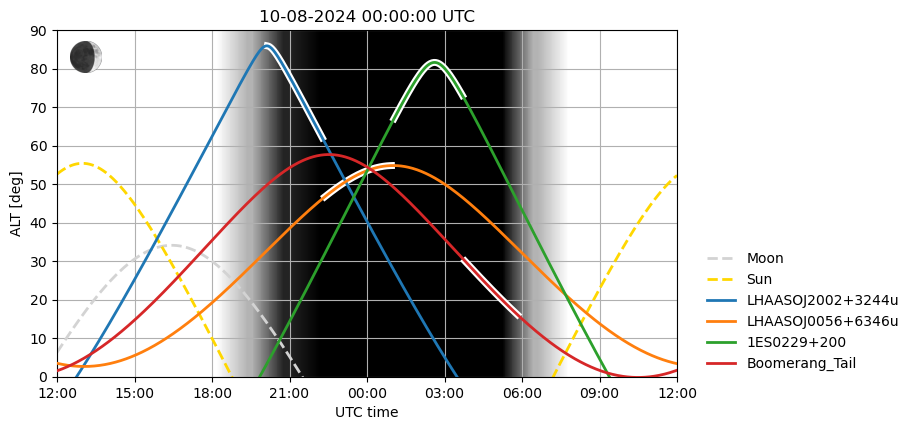

In [10]:
fig, ax = plt.subplots(figsize=(8, 4.5))

# --- Moon and Sun positions --- #
ax.plot(time_sample, moon_altaz.alt.deg, label="Moon", color="lightgray", lw=2, ls="--")
ax.plot(time_sample, sun_altaz.alt.deg, label="Sun", color="gold", lw=2, ls="--")

# --- Position of sources --- #
for k, source_altaz in enumerate(sources_altaz[:]):
    ax.plot(time_sample, source_altaz.alt.deg, "-", lw=2, label=source_names[k], zorder=10)

    ax.plot(masked_times[k], masked_alts[k], "-", color="w", lw=5, zorder=8)

# --- Dark time windows and actual time --- #
if show_time_now:
    ax.axvline(t_ref, color="r", ls="--", label="Now (UTC)")
ligh_mask_matrix = np.tile(light_mask, (5, 1))
ax.pcolormesh(time_sample, np.linspace(0,90,5), ligh_mask_matrix,  cmap="gray")

# --- Moon phase representation --- #
newax = fig.add_axes((0.11, 0.785, 0.07, 0.07), anchor="NE", zorder=1)
newax.imshow(plt.imread("data/moon_data/phase.png"))
newax.axis("off")

# --- Plot parameters --- #
ax.legend(loc=(1.04, 0), frameon=False); ax.grid()
ax.set_xlabel("UTC time"); ax.set_ylabel("ALT [deg]")
ax.set_ylim(0, 90); ax.set_xlim(time_sample[0], time_sample[-1]);
ax.set_title(t_midnight.strftime("%m-%d-%Y %H:%M:%S") + " UTC")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

if store_plots:
    plt.savefig(f"output/plot_multisource_{t_night_ref.strftime('%m-%d-%Y')}.png",
                bbox_inches="tight", dpi=400)
plt.show()

In [11]:
%%time
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})

index_init = animation_frame_indexes[0]

# --- Plotting init obs sources --- #
indexes_sources, points = [], []
for k in range(len(sources_altaz)):
    _az_, _zd_ = sources_altaz[k].az.rad[index_init], np.deg2rad(90-sources_altaz[k].alt.deg)[index_init]
    point, = ax.plot(_az_, _zd_, marker="*", ls="", ms=10, markerfacecolor=f"C{k}", 
                     label=source_names[k], zorder=10, markeredgecolor="w", markeredgewidth=0)
    indexes_sources.append(k)        
    points.append(point)
        
# --- Plotting init moon --- #
az_moon_init, zd_moon_init = moon_altaz.az.rad[index_init], np.deg2rad(90 - moon_altaz.alt.deg)[index_init]
if zd_moon_init <= np.pi / 2:
    ab_moon = AnnotationBbox(
        OffsetImage(plt.imread("data/moon_data/phase.png"), zoom=moon_zoom),
        (az_moon_init, zd_moon_init), frameon=False,
    )
    ax.add_artist(ab_moon)
    
# --- Plotting init other bodies --- #
if show_bodies:
    az_bodies, zd_bodies, ab_bodies = [], [], []
    for j, b_altaz in enumerate(bodies_altaz):
        _az_, _zd_ = b_altaz.az.rad[0], np.deg2rad(90 - b_altaz.alt.deg)[0]
        az_bodies.append(_az_)
        zd_bodies.append(_zd_)
    
        if _zd_ <= np.pi / 2:
            _ab_ = AnnotationBbox(
                OffsetImage(plt.imread(f"data/marker_images/{bodies_names[j]}.png"), zoom=bodies_zoom[j]),
                (_az_, _zd_), frameon=False,
            )
            ax.add_artist(_ab_)
            ab_bodies.append(_ab_)
            
# --- Star empty objects --- #        
if show_stars:
    stars = []
    for s, m in zip(stars_altaz, stars_mags):
        star, = ax.plot([], [], marker=utils.marker_star, ls="", c="w", ms=m ** 1.6 * 0.6, alpha=0.4)
        stars.append(star)

# --- Plotting the galplane --- #
if show_galplane:
    galplane, = ax.plot([], [], ls="-", alpha=0.5, marker="", color="w")
    galcenter, = ax.plot([], [], marker="o", alpha=0.5, color="w")

# --- Plotting GW skymap --- #
if show_gw:
    contours,  = ax.plot(np.deg2rad(az_contour[0]), np.deg2rad(90-alt_contour[0]), ".r", ms=0.9)
    ax.plot([], [], ls="-", marker="", color="r", label=f"{name_gw} (68%, 90%)")

# --- Plot parameters --- #
ax.legend(loc=(1, 0), frameon=False); ax.grid(True)
title = ax.set_title(time_sample[index_init].strftime("%m-%d-%Y %H:%M:%S") + " UTC")
ax.set_facecolor(str(light_mask[index_init]))
ax.set_ylim(0, np.pi / 2); ax.set_xlim(0, np.pi * 2)
ax.set_yticklabels([]); ax.set_theta_zero_location("N")
fig.tight_layout()

def update(i):
    print(f"{i}/{len(time_sample_reduced)} - {i/len(time_sample_reduced)*100:.2f} %") if i % np.ceil(nbins/30) == 0 else None
    
    # Moon, and sources index
    ii = np.where(time_sample == time_sample_reduced[i])[0][0]
    
    # --- Deleting objects from plot --- #
    try:
        global ab_moon
        ab_list = [ab_moon]
    except:
        ab_list = []
        pass

    if show_bodies:
        global ab_bodies
        ab_list = [*ab_list, *ab_bodies]
    for ab in ab_list:
        try:
            ab.remove()
        except:
            pass

    # --- Updating bodies positions --- #
    if show_bodies:
        ab_bodies = []
        for j, b_altaz in enumerate(bodies_altaz):
            _az_, _zd_ = b_altaz.az.rad[i], np.deg2rad(90 - b_altaz.alt.deg)[i]
            if _zd_ <= np.pi / 2:
                _ab_ = AnnotationBbox(
                    OffsetImage(plt.imread(f"data/marker_images/{bodies_names[j]}.png"), zoom=bodies_zoom[j]),
                    (_az_, _zd_), frameon=False,
                )
                ax.add_artist(_ab_)
                ab_bodies.append(_ab_)
                
    # --- Updating star positions --- #    
    if show_stars:
        for k in range(len(stars)):
            if light_mask[ii] > 0.95:
                _az_, _zd_ = [], []
            else:
                _az_, _zd_ = np.deg2rad(stars_altaz[k][i].az.deg), np.deg2rad(90 - stars_altaz[k][i].alt.deg)
            stars[k].set_xdata([_az_])
            stars[k].set_ydata([_zd_])

    # --- Updating galactic plane --- #
    if show_galplane:         
        if light_mask[ii] > 0.95:
            az_with_gaps, zd_with_gaps, az_c, zd_c = [], [], [], []
        else:
            az, zd = galplane_az_time[i], galplane_zd_time[i]
            az_c, zd_c = [galcen_altaz[i].az.rad], [np.pi/2 - galcen_altaz[i].alt.rad]

            # Calculating cartesian position over polar representation
            xx = zd * np.cos(az)
            yy = zd * np.sin(az)
            
            threshold = 1  # Define a distance threshold
            distances = np.sqrt((xx[1:]-xx[:-1])**2 + (yy[1:]-yy[:-1])**2)
            
            # Insert NaN where the distance is too large
            az_with_gaps = np.copy(az)
            zd_with_gaps = np.copy(zd)
            
            # Set NaN values for the points that exceed the threshold
            for j in range(len(distances)-1):
                if distances[j] > threshold:
                    az_with_gaps[j+1] = np.nan
                    zd_with_gaps[j+1] = np.nan

        galplane.set_xdata(az_with_gaps)
        galplane.set_ydata(zd_with_gaps)
        galcenter.set_xdata(az_c)
        galcenter.set_ydata(zd_c)

    # --- Updating moon's position --- #
    az_moon, zd_moon = moon_altaz.az.rad[ii], np.deg2rad(90 - moon_altaz.alt.deg)[ii]
    if zd_moon <= np.pi / 2:
        ab_moon = AnnotationBbox(
            OffsetImage(plt.imread("data/moon_data/phase.png"), zoom=moon_zoom),
            (az_moon, zd_moon), frameon=False,
        )
        ax.add_artist(ab_moon)
    
    # --- Updating source positions --- #
    for k, index in zip(range(len(points)), indexes_sources):
        _az_, _zd_ = sources_altaz[index].az.rad[ii], np.deg2rad(90-sources_altaz[index].alt.deg)[ii]
        points[k].set_xdata([_az_])
        points[k].set_ydata([_zd_])

        # If in observation we put a white edge
        if masks_obstime[index][ii]:
            points[k].set_markeredgewidth(1)
        else:
            points[k].set_markeredgewidth(0)

    # --- Updating background color and title --- #
    ax.set_facecolor(str(light_mask[ii]))
    title.set_text(time_sample[ii].strftime("%m-%d-%Y %H:%M:%S") + " UTC")

    # --- Updating GW skymap --- #
    if show_gw:
        contours.set_xdata(np.deg2rad(az_contour[i]))
        contours.set_ydata(np.deg2rad(90-alt_contour[i]))

    return points[0],

ani = animation.FuncAnimation(fig, update, frames=len(animation_frame_indexes), interval=1, blit=True)
ani.save(f"output/anim_{t_night_ref.strftime('%m-%d-%Y')}.{animation_format}", writer="ffmpeg", 
         fps=80, dpi=300)
plt.close()

0/511 - 0.00 %
0/511 - 0.00 %
0/511 - 0.00 %
0/511 - 0.00 %
24/511 - 4.70 %
48/511 - 9.39 %
72/511 - 14.09 %
96/511 - 18.79 %
120/511 - 23.48 %
144/511 - 28.18 %
168/511 - 32.88 %
192/511 - 37.57 %
216/511 - 42.27 %
240/511 - 46.97 %
264/511 - 51.66 %
288/511 - 56.36 %
312/511 - 61.06 %
336/511 - 65.75 %
360/511 - 70.45 %
384/511 - 75.15 %
408/511 - 79.84 %
432/511 - 84.54 %
456/511 - 89.24 %
480/511 - 93.93 %
504/511 - 98.63 %
CPU times: user 4min 57s, sys: 3min 47s, total: 8min 44s
Wall time: 4min 41s
